# HSE 2025: Mathematical Methods for Data Analysis

## Homework 4

**Warning 1**: You have 10 days for this assignemnt.  **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells


### Contents

#### Decision Trees - 4 points
* [Task 1](#task1) (0.25 points)
* [Task 2](#task2) (0.25 points)
* [Task 3](#task3) (1 points)
* [Task 4](#task4) (0.5 points)
* [Task 5](#task5) (0.5 points)
* [Task 6](#task6) (1 points)
* [Task 7](#task7) (0.5 points)
* [Task 8](#task8) (0.5 points)

#### Ensembles - 4 points
* [Task 1](#task2_1) (0.25 point)
* [Task 2](#task2_2) (1.5 points)
* [Task 3](#task2_3) (0.25 points)
* [Task 4](#task2_4) (0.5 points)
* [Task 5](#task2_4) (0.5 points)

#### Ensembles - 2 points
* [Task 1](#task2_1) (0.4 point)
* [Task 2](#task2_2) (0.5 points)
* [Task 3](#task2_3) (0.5 points)
* [Task 4](#task2_4) (0.5 points)
* [Task 5](#task2_4) (0.1 points)

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

plt.rcParams['figure.figsize'] = (11, 5)
%matplotlib inline

# Part 1. Decision Tree Regressor

In this task you will be implementing decision tree for the regression by hand.

### Task 1 <a id="task1"></a> (0.25 points)

Here you should implement the function `H()` which calculates impurity criterion. We will be training regression tree, and will take mean absolute deviation as impurity criterion.

* You cannot use loops
* If `y` is empty, the function should return 0

In [ ]:
def H(y):
    """
    Calculate impurity criterion

    Parameters
    ----------
    y : np.array
        array of objects target values in the node

    Returns
    -------
    H(R) : float
        Impurity in the node (measuread by variance)
    """
    if len(y) == 0:
        return 0.0
    return np.mean(np.abs(y - np.mean(y)))

In [ ]:
# Test the function
assert np.allclose(H(np.array([4, 2, 2, 2])), 0.75)
assert np.allclose(H(np.array([])), 0.0)

### Task 2 <a id="task2"></a>  (0.25 points)

To find the best split in the node we need to calculate the cost function. Denote:
- `R` all the object in the node
- `j` index of the feature selected for the split
- `t` threshold
- `R_l` and `R_r` objects in the left and right child nodes correspondingly

We get the following cost function:

$$
Q(R, j, t) =\frac{|R_\ell|}{|R|}H(R_\ell) + \frac{|R_r|}{|R|}H(R_r) \to \min_{j, t},
$$

Implement the function `Q`, which should calculate value of the cost function for a given feature and threshold.

In [ ]:
def Q(X, y, j, t):
    """
    Calculate cost function
    Parameters
    ----------
    X : ndarray
        array of objects in the node
    y : ndarray
        array of target values in the node
    j : int
        feature index (column in X)
    t : float
        threshold

    Returns
    -------
    Q : float
        Value of the cost function
    """
    X_j = X[:, j]
    y_left = y[X_j < t]
    y_right = y[X_j >= t]
    Q = (y_left.size * H(y_left) + y_right.size * H(y_right)) / y.size
    return Q

### Task 3 <a id="task3"></a>  (1 points)

Now, let's implement `MyDecisionTreeRegressor` class. More specifically, you need to implement the following methods:

- `best_split`
- `grow_tree`
- `get_prediction`

Also, please add `min_samples_leaf` parameter to your class

Read docstrings for more details. Do not forget to use function `Q` implemented above, when finding the `best_split`

In [ ]:
class Node(object):
    """
    Class for a decision tree node.

    Parameters
    ----------
    right : Node() or None
        Right child
    left : Node() or None
        Left child
    threshold: float

    column: int

    depth: int

    prediction: float
        prediction of the target value in the node
        (average values calculated on a train dataset)
    is_terminal:bool
        indicates whether it is a terminal node (leaf) or not
    """
    def __init__(self):
        self.right = None
        self.left = None
        self.threshold = None
        self.column = None
        self.depth = None
        self.is_terminal = False
        self.prediction = None

    def __repr__(self):
        if self.is_terminal:
            node_desc = 'Pred: {:.2f}'.format(self.prediction)
        else:
            node_desc = 'Col {}, t {:.2f}, Pred: {:.2f}'. \
            format(self.column, self.threshold, self.prediction)
        return node_desc

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, validate_data

class MyDecisionTreeRegressor(RegressorMixin, BaseEstimator):
    """
    Class for a Decision Tree Regressor.

    Parameters
    ----------
    max_depth : int
        Max depth of a decision tree.
    min_samples_split : int
        Minimal number of samples (objects) in a node to make a split.
    min_samples_leaf: int
        Minimum number of samples (objects) in left and right branches after splitting the current node
    """
    def __init__(self, max_depth=3, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf

    def best_split(self, X, y):
        """
        Find the best split in terms of Q of data in a given decision tree node.
        Try all features and thresholds.

        Parameters
        ----------
        X : ndarray, shape (n_objects, n_features)
            Objects in the parent node
        y : ndarray, shape (n_objects, )
            1D array with the object labels.

        Returns
        -------
        best_split_column : int
            Index of the best split column
        best_threshold : float
            The best split condition.
        X_left : ndarray, shape (n_objects_l, n_features)
            Objects in the left child
        y_left : ndarray, shape (n_objects_l, )
            Objects labels in the left child.
        X_right : ndarray, shape (n_objects_r, n_features)
            Objects in the right child
        y_right : ndarray, shape (n_objects_r, )
            Objects labels in the right child.
        """

        best_split_column = None
        best_threshold = None
        best_cost = H(y)

        X_left, y_left, X_right, y_right = None, None, None, None

        for j in range(X.shape[1]):
            X_j = X[:, j]
            for t in np.unique(X_j):
                cost = Q(X, y, j, t)
                y_left = y[X_j < t]
                y_right = y[X_j >= t]

                if cost < best_cost and y_left.size >= self.min_samples_leaf and y_right.size >= self.min_samples_leaf:
                    best_cost = cost
                    best_split_column = j
                    best_threshold = t

        if best_split_column is not None:
            X_j = X[:, best_split_column]
            X_left = X[X_j < best_threshold]
            y_left = y[X_j < best_threshold]
            X_right = X[X_j >= best_threshold]
            y_right = y[X_j >= best_threshold]

            self.split_columns_[best_split_column] = self.split_columns_.get(best_split_column, []) + [best_threshold]

        return best_split_column, best_threshold, X_left, y_left, X_right, y_right

    def is_terminal(self, node, y):
        """
        Check terminality conditions based on `max_depth`,
        `min_samples_split` parameters for a given node.

        Parameters
        ----------
        node : Node,

        y : ndarray, shape (n_objects, )
            Object labels.

        Returns
        -------
        Is_termial : bool
            If True, node is terminal
        """
        if node.depth >= self.max_depth:
            return True
        if len(y) < self.min_samples_split:
            return True
        return False

    def grow_tree(self, node, X, y):
        """
        Reccurently grow the tree from the `node` using a `X` and `y` as a dataset:
         - check terminality conditions
         - find best split if node is not terminal
         - add child nodes to the node
         - call the function recursively for the added child nodes

        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        X : ndarray, shape (n_objects, n_features)
            Objects
        y : ndarray, shape (n_objects)
            Labels
        """

        if self.is_terminal(node, y):
            node.is_terminal =True
            return

        best_split_column, best_threshold, X_left, y_left, X_right, y_right = self.best_split(X, y)
        if best_split_column is None:
            node.is_terminal = True
            return

        node.threshold = best_threshold
        node.column = best_split_column

        node.left = Node()
        node.left.depth = node.depth + 1
        node.left.prediction = np.mean(y_left)

        node.right = Node()
        node.right.depth = node.depth + 1
        node.right.prediction = np.mean(y_right)

        self.grow_tree(node.left, X_left, y_left)
        self.grow_tree(node.right, X_right, y_right)

    def fit(self, X, y):
        """
        Fit the Decision Tree Regressor.

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        y : ndarray, shape (n_samples,) or (n_samples, n_outputs)
            The target values.
        Returns
        -------
        self : object
            Returns self.
        """
        self.split_columns_ = {}
        X, y = validate_data(self, X, y, accept_sparse=False, ensure_2d=True, y_numeric=True)
        self.is_fitted_ = True
        self.n_features_in_ = X.shape[1]

        self.tree_ = Node()
        self.tree_.depth = 0
        self.tree_.prediction = np.mean(y)

        self.grow_tree(self.tree_, X, y)
        return self

    def get_prediction(self, node, x):
        """
        Get prediction for an object `x`
            - Return prediction of the `node` if it is terminal
            - Otherwise, recursively call the function to get
            predictions of the proper child

        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        x : ndarray, shape (n_features,)
            Array of feature values of one object.
        Returns
        -------
        y_pred : float
            Prediction for an object x
        """
        if node.is_terminal:
            return node.prediction

        if (x[node.column] < node.threshold):
            return self.get_prediction(node.left, x)

        return self.get_prediction(node.right, x)

    def predict(self, X):
        """
        Get prediction for each object in X

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns predictions.
        """
        X = validate_data(self, X, accept_sparse=False, ensure_2d=True, reset=False)
        check_is_fitted(self, 'is_fitted_')

        y_predicted = []
        for x in X:
            y_curr = self.get_prediction(self.tree_, x)
            y_predicted.append(y_curr)
        return np.array(y_predicted)

In [ ]:
# check yourself
from sklearn.utils.estimator_checks import check_estimator

check_estimator(MyDecisionTreeRegressor())

[{'estimator': MyDecisionTreeRegressor(),
  'check_name': 'check_estimator_cloneable',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': False,
  'expected_to_fail_reason': 'Check is not expected to fail'},
 {'estimator': MyDecisionTreeRegressor(),
  'check_name': 'check_estimator_cloneable',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': False,
  'expected_to_fail_reason': 'Check is not expected to fail'},
 {'estimator': MyDecisionTreeRegressor(),
  'check_name': 'check_estimator_tags_renamed',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': False,
  'expected_to_fail_reason': 'Check is not expected to fail'},
 {'estimator': MyDecisionTreeRegressor(),
  'check_name': 'check_valid_tag_types',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': False,
  'expected_to_fail_reason': 'Check is not expected to fail'},
 {'estimator': MyDecisionTreeRegressor(),
  'check_name': 'check_estimator_repr',
  'exception': None,
  'status'

### Task 4 <a id="task4"></a>  (0.5 points)

Load california housing dataset and split it on the train ($75\%$) and test ($25\%$). Fit Decision Tree of **depth 1 and 2** (root node has **depth 0**) and make the following plot for every case :

- Scatter plot of the traning points for each splitted feature (selected for split feature on the x-axis, target variable on the y-axis). Show the resulting thresholds

After that, fit analogical model from sklearn and visual it

Compare `MAE` on train and test. Have trees overfitted?

In [ ]:
from sklearn.datasets import fetch_california_housing
cal = fetch_california_housing(as_frame=True)
df = cal.frame
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [ ]:
y = df['MedHouseVal']
X = df.drop('MedHouseVal', axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
) # разделяем данные

In [ ]:
dt_depth1 = DecisionTreeRegressor(max_depth=1, random_state=42)
dt_depth2 = DecisionTreeRegressor(max_depth=2, random_state=42)

In [ ]:
dt_depth1.fit(X_train, y_train)
dt_depth2.fit(X_train, y_train) # обучаем модели

DecisionTreeRegressor(max_depth=2, random_state=42)

глубина 1 - корневое разбиение:
признак: MedInc
порог: 5.0316


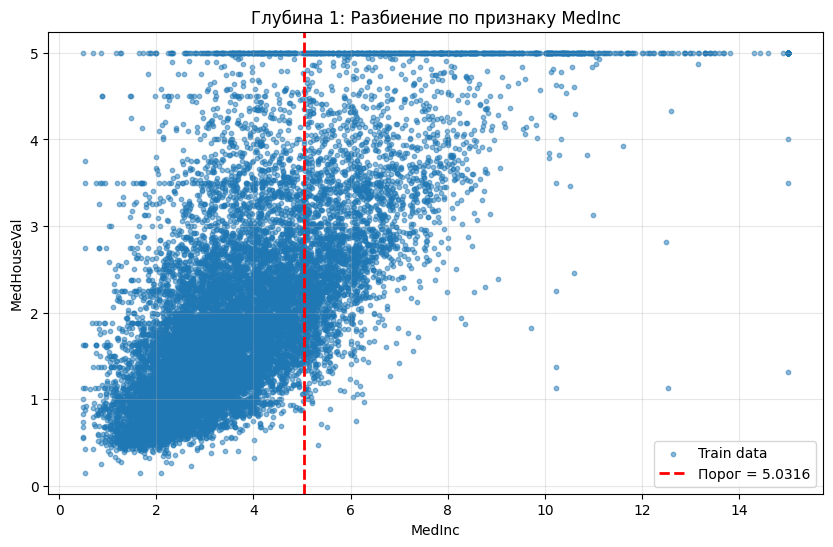

In [ ]:

root_feature_idx = dt_depth1.tree_.feature[0]
root_threshold = dt_depth1.tree_.threshold[0]
root_feature_name = X.columns[root_feature_idx]

print(f"глубина 1 - корневое разбиение:")
print(f"признак: {root_feature_name}") # выбран MedInc
print(f"порог: {root_threshold:.4f}")

# рисуем график
plt.figure(figsize=(10, 6))
plt.scatter(X_train[root_feature_name], y_train,
           alpha=0.5, s=10, label='Train data')
plt.axvline(x=root_threshold, color='red', linestyle='--',
           linewidth=2, label=f'Порог = {root_threshold:.4f}')
plt.xlabel(root_feature_name)
plt.ylabel('MedHouseVal')
plt.title(f'Глубина 1: Разбиение по признаку MedInc')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

глубина 2 - все разбиения:
узел 0: MedInc <= 5.0316
узел 1: MedInc <= 3.0743
узел 4: MedInc <= 7.0231


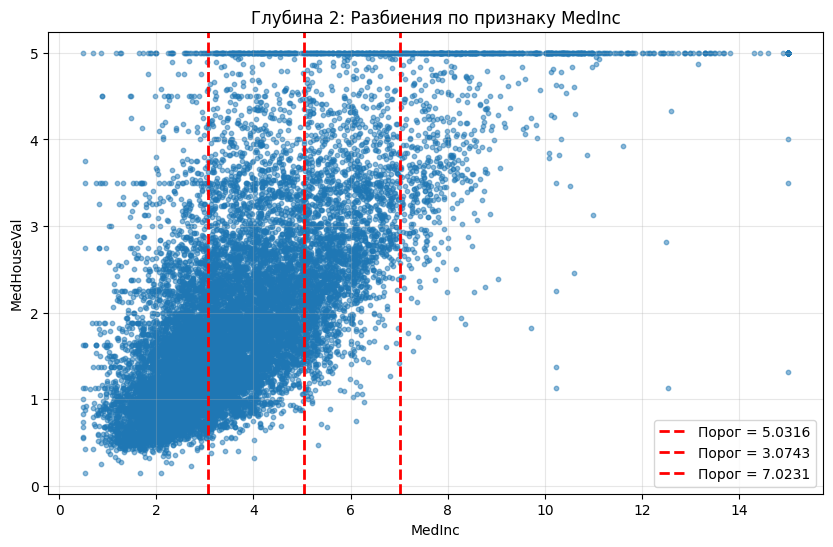

In [ ]:
tree_struct = dt_depth2.tree_

print("глубина 2 - все разбиения:")
for i in range(tree_struct.node_count):
    if tree_struct.feature[i] >= 0:
        feat_name = X.columns[tree_struct.feature[i]]
        threshold = tree_struct.threshold[i]
        print(f"узел {i}: {feat_name} <= {threshold:.4f}")

split_features = set()
for i in range(tree_struct.node_count):
    if tree_struct.feature[i] >= 0:
        #print(tree_struct.feature[i])
        split_features.add(tree_struct.feature[i]) # все разбиения по MedInc

for feat_idx in split_features:
    feat_name = X.columns[feat_idx]

    plt.figure(figsize=(10, 6))
    plt.scatter(X_train[feat_name], y_train, alpha=0.5, s=10)
    for i in range(tree_struct.node_count):
        if tree_struct.feature[i] == feat_idx:
            threshold = tree_struct.threshold[i]
            plt.axvline(x=threshold, color='red', linestyle='--',
                       linewidth=2, label=f'Порог = {threshold:.4f}')

    plt.xlabel(feat_name)
    plt.ylabel('MedHouseVal')
    plt.title(f'Глубина 2: Разбиения по признаку MedInc')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

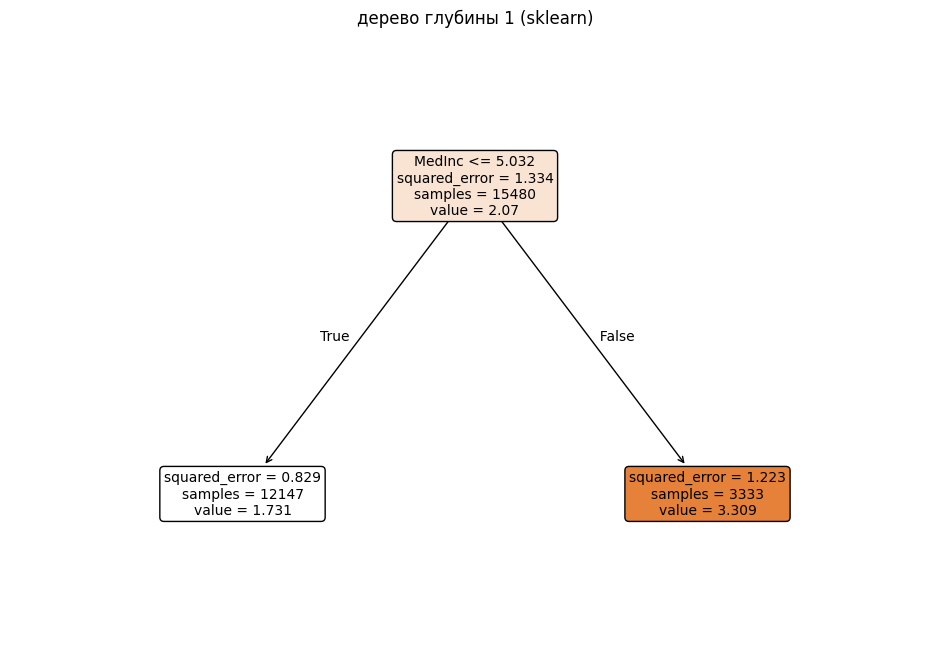

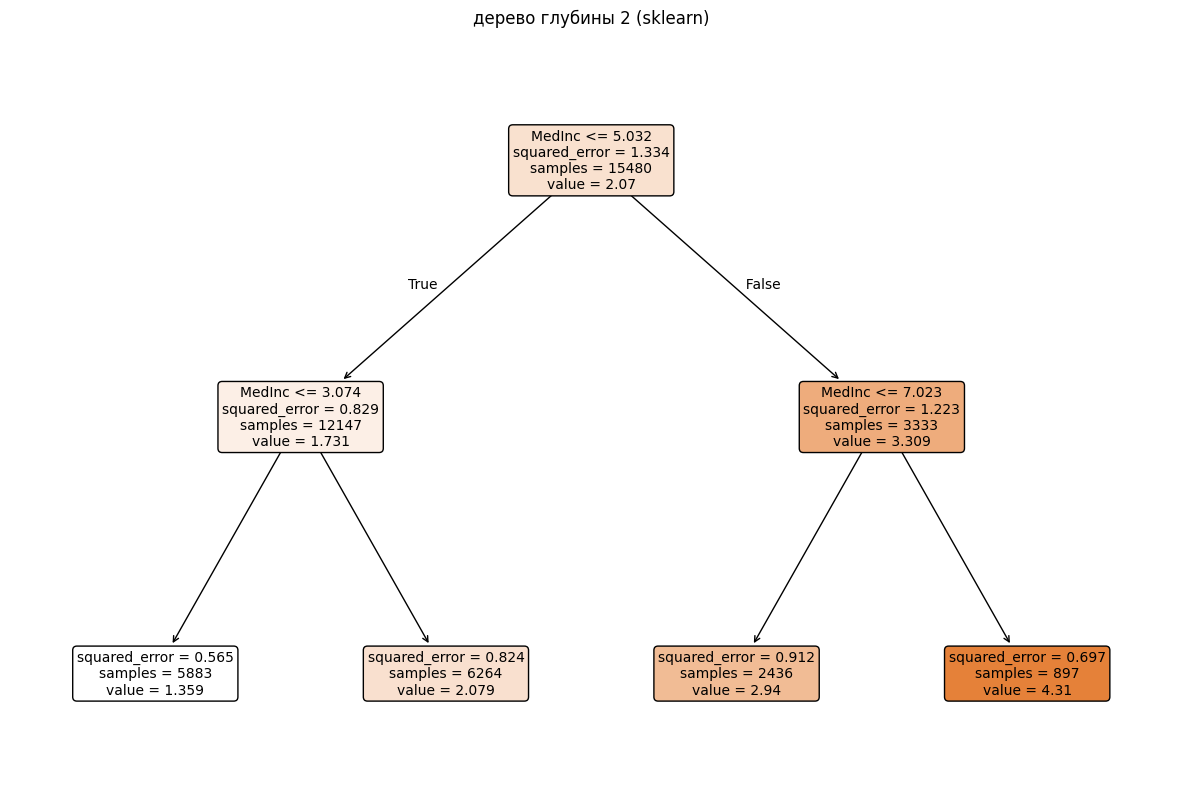

In [ ]:
from sklearn import tree
import graphviz

# для глубины 1
plt.figure(figsize=(12, 8))
tree.plot_tree(dt_depth1, feature_names=X.columns,
               filled=True, rounded=True, fontsize=10)
plt.title("дерево глубины 1 (sklearn)")
plt.show()

# для глубины 2
plt.figure(figsize=(15, 10))
tree.plot_tree(dt_depth2, feature_names=X.columns,
               filled=True, rounded=True, fontsize=10)
plt.title("дерево глубины 2 (sklearn)")
plt.show()

In [ ]:
def calculate_mae(model, X, y):
    predictions = model.predict(X)
    return mean_absolute_error(y, predictions)

In [ ]:
print("Сравнение MAE:")

for name, model in [("глубина 1", dt_depth1), ("глубина 2", dt_depth2)]:
    mae_train = calculate_mae(model, X_train, y_train)
    mae_test = calculate_mae(model, X_test, y_test)

    print(f"\n{name}:")
    print(f"Train MAE:{mae_train:.4f}")
    print(f"Test MAE: {mae_test:.4f}")
    print(f"Разница:  {mae_test - mae_train:.4f}")

Сравнение MAE:

глубина 1:
Train MAE:0.7416
Test MAE: 0.7524
Разница:  0.0109

глубина 2:
Train MAE:0.6509
Test MAE: 0.6614
Разница:  0.0105


По результатам видим, что модель глубины 2 показывает значительное улучшение по сравнению с моделью глубины 1: MAE уменьшился на 12% как на тренировочных, так и на тестовых данных (с 0.74 до 0.65 и с 0,75 до 0,66). При этом разрыв между ошибками на train и test остался минимальным и практически неизменным: 0.0109 для глубины 1 и 0.0105 для глубины 2, что составляет всего около 1.5% от соответствующих значений MAE, и вроде бы не указывает на точное переобучение.

модель стала существенно лучше предсказывать (уменьшилась ошибка), но не приобрела переобучения, так что увеличение глубины с 1 до 2 уровней оправдано, так как мы получили более точную модель, но при этом не получили переобучения.

### Task 5 <a id="task5"></a> (0.5 points)

Keep working with the Boston dataset.

- Use [Optuna](https://github.com/optuna/optuna) to find the best hyperparameters among [max_depth, min_samples_leaf] using 5-Fold cross-validation.

- Train the model with the best set of hyperparameters on the whole training dataset.

- Report the MAE on the test dataset and the hyperparameters of the best estimator.

[Optuna](https://github.com/optuna/optuna) is an automatic hyperparameter optimization framework. It searches for the best parameters using efficient algorithms (e.g., Tree-structured Parzen Estimator — TPE). It is model-agnostic and works with any Python ML framework. Use TPE algorithms for all tasks.

Кто такой Бостон датасет, у нас же Калифорния...

ну ладно.

In [ ]:
df = pd.read_csv('boston_house_prices.csv') # сказали использовать этот
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [ ]:
y = df['TARGET']
X = df.drop('TARGET', axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [ ]:
pip install optuna -q

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer
import optuna

def objective(trial):
    max_depth = trial.suggest_int('max_depth', 1, 30)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 50)

    model = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    scores = -cross_val_score(
        model, X_train, y_train,
        cv=kfold,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )

    return np.mean(scores)

In [ ]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=50)

[I 2025-12-04 21:53:19,400] A new study created in memory with name: no-name-c2fd98f0-8dd4-4f34-aa6b-feb0f0746485
[I 2025-12-04 21:53:21,914] Trial 0 finished with value: 3.933030916518778 and parameters: {'max_depth': 12, 'min_samples_leaf': 48}. Best is trial 0 with value: 3.933030916518778.
[I 2025-12-04 21:53:22,012] Trial 1 finished with value: 3.720389320711745 and parameters: {'max_depth': 22, 'min_samples_leaf': 30}. Best is trial 1 with value: 3.720389320711745.
[I 2025-12-04 21:53:22,062] Trial 2 finished with value: 3.2207579705945037 and parameters: {'max_depth': 5, 'min_samples_leaf': 8}. Best is trial 2 with value: 3.2207579705945037.
[I 2025-12-04 21:53:22,121] Trial 3 finished with value: 4.110970421833683 and parameters: {'max_depth': 2, 'min_samples_leaf': 44}. Best is trial 2 with value: 3.2207579705945037.
[I 2025-12-04 21:53:22,187] Trial 4 finished with value: 3.7338809267159974 and parameters: {'max_depth': 19, 'min_samples_leaf': 36}. Best is trial 2 with value:

In [ ]:
# лучшие гиперпараметры
print("Лучшие гиперпараметры:", study.best_params)

best_model = DecisionTreeRegressor(
    **study.best_params,
    random_state=42
)
best_model.fit(X_train, y_train)

Лучшие гиперпараметры: {'max_depth': 17, 'min_samples_leaf': 18}


DecisionTreeRegressor(max_depth=17, min_samples_leaf=18, random_state=42)

In [ ]:
y_test_pred = best_model.predict(X_test)

test_mae = mean_absolute_error(y_test, y_test_pred)
print(f"MAE на тестовом наборе: {test_mae:.4f}")

MAE на тестовом наборе: 3.0462


In [ ]:
print(f"Лучшие гиперпараметры: {study.best_params}")
print(f"MAE на тестовом наборе: {test_mae:.4f}")
print(f"Лучшее CV MAE: {study.best_value:.4f}")

Лучшие гиперпараметры: {'max_depth': 17, 'min_samples_leaf': 18}
MAE на тестовом наборе: 3.0462
Лучшее CV MAE: 3.0812


Оптимальной получилась достаточно глубокая модель, но не максимальная (17 уровней глубины). В каждом листе должно быть минимум 18 образцов.

Тестовая ошибка ниже, чем CV ошибка, модель не переобучилась. Целевая переменная это стоимость домов в тысячах долларах, значит что в среднем предсказания отличаются от реальной цены на 3 тысячи долларов. Вроде бы нормальный результат, но наверное RF или GB покажут лучше.

### Task 6 <a id="task6"></a>  (1 points)

Recall definition of bias and variance:
$$
\text{Bias}^2 = \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] \\
\text{Variance} = \mathbb{E}_{p(x, y)} \left[  \mathbb{V}_{\mathbb{X}}( a_{\mathbb{X}}(x))  \right]
$$

We wil now use the following algorithm to estimate bias and variance:

1. Use bootsrap to create `n_iter` samples from the original dataset: $X_1, \dots, X_{n_iter}$
2. For each bootstrapped sample define out-of-bag (OOB) sample $Z_1, \dots, Z_{n_iter}$, which contain all the observations, which did not appear in the corresponding boostraped sample
3. Fit the model on $X_i$s and compute predictions on $Z_i$s
4. For a given *object* $n$:
     - bias^2: squared difference between true value $y_n$ and average prediction (average over the algorithms, for which $n$ was in OOB)
     - variance: variance of the prediction (predictions of the algorithms, for which $n$ was in OOB)
5. Average bias^2 and variance over all the points
    
**Implement `get_bias_variance` function, using the algorithm above**

*Note:*  You can only use 1 loop (for bootsrap iterations). All other operations should be vectorized.

In [ ]:
def get_bias_variance(estimator, x, y, n_iter):
    """
    Calculate bias and variance of the `estimator`.
    Using a given dataset and bootstrap with `n_iter` samples.

    Parameters
    ----------
    x : ndarray, shape (n_samples, n_features)
        The input samples.
    y : ndarray, shape (n_samples, n_features)
        The input samples.
    n_iter: int
        Number of samples in
    Returns
    -------
    bias2 : float,
        Estiamted squared bias
    variance : float,
        Estiamted variance
    """

    np.random.seed(42)
    n_samples = x.shape[0]

    y_pred = np.empty(x.shape)
    y_pred[:] = np.nan

    for bootstrap_iter in range(n_iter):
        idx = np.random.choice(n_samples, size=n_samples, replace=True)
        mask = np.ones(n_samples, dtype=bool)
        mask[idx] = False

        X = x[idx]
        Z = x[mask]

        estimator.fit(X, y[idx])
        y_pred[mask, bootstrap_iter] = estimator.predict(Z)

    return np.nanmean((y - np.nanmean(y_pred, axis=1)) ** 2), np.nanmean(np.nanvar(y_pred, axis=1))

In [ ]:
# Test
estimator = MyDecisionTreeRegressor(max_depth=8, min_samples_split=15)

dt_bias, dt_var = get_bias_variance(estimator, X_train.values, y_train.values, 10)

### Task 7 <a id="task7"></a>  (0.5 points)

Compute bias and variance for the trees with different min_samples_split. Plot how bias and variance change as min_samples_split increases.

Comment on what you observe, how does your result correspond to theory?

In [ ]:
def collect_bias_variance(start, stop, step):
    min_samples_split_range = np.arange(start, stop, step)
    biases = []
    variances = []

    for min_samples_split in min_samples_split_range:
        bias, variance = get_bias_variance(MyDecisionTreeRegressor(max_depth=8, min_samples_split=min_samples_split), X_train.values, y_train.values, 10)
        biases.append(bias)
        variances.append(variance)

    return min_samples_split_range, biases, variances

In [ ]:
mss, biases, variances = collect_bias_variance(1, 100, 1)

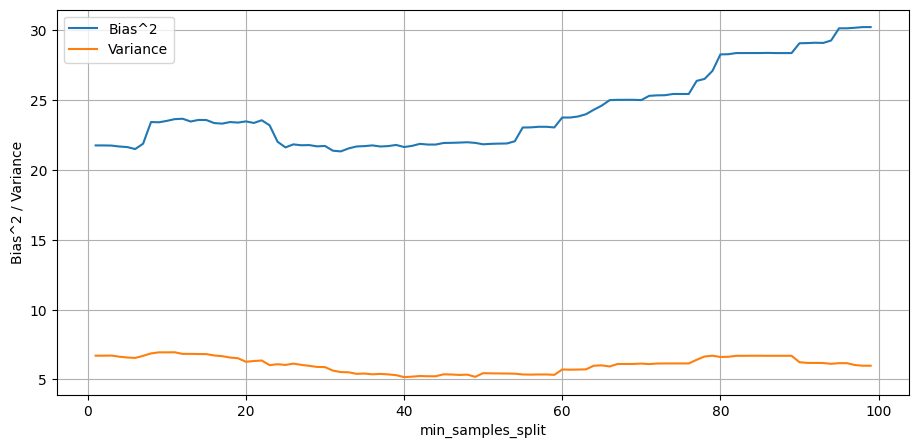

In [ ]:
plt.plot(mss, biases, label="Bias^2")
plt.plot(mss, variances, label="Variance")
plt.xlabel('min_samples_split')
plt.ylabel('Bias^2 / Variance')
plt.legend()
plt.grid(True)
plt.show()

График показывает, что дисперсия остается на том же уровне с увеличением минимального числа образцов, но смещение высокое и растет. Это указывает на то, что модель недообучается.

У нас смещение растет, но дисперсия не падает достаточно сильно - значит, дерево все еще слишком сложное даже при больших min_samples_split из-за ограниченной глубины.

### Task 8 <a id="task8"></a>  (0.5 points)

Let's try to reduce variance with bagging. Use `sklearn.ensemble.BaggingRegressor` to get an ensemble and compute its bias and variance.

Answer the following questions:
 - How bagging should affect bias and variance in theory?
 - How bias and variance change (if they change) compared to an individual tree in you experiments?
 - Do your results align with the theory? Why?

In [ ]:
from sklearn.ensemble import BaggingRegressor

br = BaggingRegressor(estimator=MyDecisionTreeRegressor(max_depth=8, min_samples_split=15), random_state=42)
br_bias, br_var = get_bias_variance(br, X_train.values, y_train.values, 10)

In [ ]:
results_df = pd.DataFrame({
    'Model': ['Decision Tree', 'Bagging Ensemble'],
    'Bias^2': [dt_bias, br_bias],
    'Variance': [dt_var, br_var]
})

results_df

,Model,Bias^2,Variance
0,Decision Tree,23.564203,6.813767
1,Bagging Ensemble,16.996445,1.726021


Bagging сработал очень хорошо - уменьшил и смещение и дисперсию, хотя в теории должен влиять только на дисперсию (уменьшать).

Возможно так произошло, так как ансамль лучше обучается на данных, когда  разные деревья видят разные части данных, а предыдущее одиночное дерево вдобавок было недоученным.

# Part 2. Gradient Boosting

In this assignment, you will implement a Gradient Boosting model for binary classification.

The base learners in your model must be the decision trees you have implemented earlier (**MyDecisionTreeRegressor** and **Node**).

The loss function used for boosting will be the logistic (log-loss) loss, as used in logistic regression.


We assume binary labels: $y \in {0, 1}$

The model builds an additive ensemble:
$ F(x) = F_0 + \sum_{m=1}^{M} \eta \cdot h_m(x) $

where:

•	$F(x)$ are raw scores (logits),

•	$F_0$ is the initial prediction computed from the training data,

•	$\eta$ is the learning rate,

•	$h_m(x)$ are predictions of the (m)-th regression tree.


The predicted probability for class 1 must be computed using the sigmoid transformation: $p(x) = \sigma(F(x)) = \frac{1}{1 + e^{-F(x)}}$


### Task 1 <a id="task2_1"></a>  (0.25 points)

In this task, you must derive the expression for the residuals used in Gradient Boosting with logistic loss, which is employed in binary classification.

$L(y, F(x)) = - \Big( y \cdot \log(p(x)) + (1 - y) \cdot \log(1 - p(x)) \Big)$

Иммем:
$p(x) = \sigma(F(x)) = \frac{1}{1 + e^{-F(x)}}$  
$L(y, F) = -[y \log p + (1-y) \log(1-p)]$

Найдем производную по F:

$\frac{\partial L}{\partial F} = -\left[y \cdot \frac{1}{p} \cdot \frac{\partial p}{\partial F} + (1-y) \cdot \frac{1}{1-p} \cdot \left(-\frac{\partial p}{\partial F}\right)\right]$

Теперь найдем $\frac{\partial p}{\partial F}$ для сигмоиды:

$p = \sigma(F) = \frac{1}{1 + e^{-F}}$

Производная сигмоиды:
$\frac{\partial p}{\partial F} = p \cdot (1 - p)$

Подставляем:

$\frac{\partial L}{\partial F} = -\left[y \cdot \frac{1}{p} \cdot p(1-p) - (1-y) \cdot \frac{1}{1-p} \cdot p(1-p)\right]$

$\frac{\partial L}{\partial F} = -\left[y(1-p) - (1-y)p\right]$
$\frac{\partial L}{\partial F} = -\left[y - yp - p + yp\right]$
$\frac{\partial L}{\partial F} = -\left[y - p\right]$

Получаем:

$\frac{\partial L}{\partial F} = p - y$

Так как в градиентном бустинге мы обучаем каждое новое дерево $h_m(x)$ предсказывать отрицательный градиент:

$r_i = -\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}$

Следовательно:

$r_i = y_i - p(x_i)$

### Task 2 <a id="task2_2"></a>  (1.5 points)

Implement class for Gradient Boosting model for binary classification.

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.special import expit

class MyGradientBoostingBinaryClassifier(BaseEstimator, ClassifierMixin):
    """
    Gradient boosting for binary classification (y in {0, 1})
    using MyDecisionTreeRegressor as the underlying algorithm.
    """
    def __init__(self,
                 n_estimators=50,
                 learning_rate=0.1,
                 max_depth=1,
                 min_samples_split=2,
                 min_samples_leaf=1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.trees_ = []
        self.initial_prediction_ = None

    def fit(self, X, y):
        """
        Training gradient boosting.
        """
        y = np.asarray(y)
        p = np.mean(y)
        epsilon = 1e-15
        p = np.clip(p, epsilon, 1 - epsilon)
        self.initial_prediction_ = np.log(p / (1 - p))

        F = np.full_like(y, self.initial_prediction_, dtype=np.float64)

        for _ in range(self.n_estimators):
            p_current = expit(F)
            residuals = y - p_current

            tree = MyDecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf
            )
            tree.fit(X, residuals)
            self.trees_.append(tree)

            tree_pred = tree.predict(X)
            F += self.learning_rate * tree_pred

        return self

    def _raw_scores(self, X):
        """
        F(x) = F0 + sum(eta * tree_k(x))
        """
        scores = np.full(X.shape[0], self.initial_prediction_, dtype=np.float64)

        for tree in self.trees_:
            scores += self.learning_rate * tree.predict(X)

        return scores

    def predict_proba(self, X):
        """
        Return class probs [P(y=0), P(y=1)]
        """
        scores = self._raw_scores(X)
        proba_class1 = expit(scores)
        proba_class0 = 1 - proba_class1

        return np.column_stack([proba_class0, proba_class1])

    def predict(self, X):
        """
        Return labels 0 and 1.
        """
        probas = self.predict_proba(X)
        y_pred = (probas[:, 1] >= 0.5).astype(int)
        return y_pred

### Task 3 <a id="task2_3"></a>  (0.25 points)

In this task, you will work with the breast cancer dataset to solve a binary classification problem by predicting passenger survival (0 or 1).

You must load the dataset, preprocess it by handling missing values and encoding categorical features, and then split it into three parts: 60% for training, 20% for validation, and 20% for testing using an appropriate random splitting method.

The prepared datasets will be used later to train a custom Gradient Boosting model and evaluate its performance.

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

bc = load_breast_cancer(as_frame=True)
df = bc.frame
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [ ]:
print(df.isnull().sum().sum()) # нет пропущенных

0


In [ ]:
print(df.dtypes) # только числовые данные...

mean radius                float64
mean texture               float64
mean perimeter             float64
mean area                  float64
mean smoothness            float64
mean compactness           float64
mean concavity             float64
mean concave points        float64
mean symmetry              float64
mean fractal dimension     float64
radius error               float64
texture error              float64
perimeter error            float64
area error                 float64
smoothness error           float64
compactness error          float64
concavity error            float64
concave points error       float64
symmetry error             float64
fractal dimension error    float64
worst radius               float64
worst texture              float64
worst perimeter            float64
worst area                 float64
worst smoothness           float64
worst compactness          float64
worst concavity            float64
worst concave points       float64
worst symmetry      

In [ ]:
X = df.drop('target', axis=1)
y = df['target']

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(341, 30)
(114, 30)
(114, 30)


In [ ]:
print("Баланс классов в train:")
print(y_train.value_counts())
print(f"Процент класса 1: {y_train.mean():.2%}")

Баланс классов в train:
target
1    209
0    132
Name: count, dtype: int64
Процент класса 1: 61.29%


In [ ]:
print("Validation баланс:")
print(y_val.value_counts())

print("Test баланс:")
print(y_test.value_counts())

Validation баланс:
target
1    72
0    42
Name: count, dtype: int64
Test баланс:
target
1    76
0    38
Name: count, dtype: int64


### Task 4 <a id="task2_4"></a>  (0.5 points)

Find optimal hyperparameters for your custom Gradient Boosting binary classification model using the [Optuna](https://github.com/optuna/optuna) framework (about 30 Trials or more), optimizing the F1 score on the validation dataset. After selecting the best hyperparameters, train the model on the training data using these values, and then evaluate its performance by computing the F1 score on the test set.

In [ ]:
from sklearn.metrics import f1_score

def objective2(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    max_depth = 1
    min_samples_split = 2
    min_samples_leaf = 1

    model = MyGradientBoostingBinaryClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )

    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)

    return f1_score(y_val, y_val_pred)

In [ ]:
import optuna
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)
)

study.optimize(objective2, n_trials=30)

[I 2025-12-04 21:59:30,370] A new study created in memory with name: no-name-34ecde08-27bf-49d2-9928-d308b38b2fd3
[I 2025-12-04 21:59:45,288] Trial 0 finished with value: 0.9655172413793104 and parameters: {'n_estimators': 44, 'learning_rate': 0.2536999076681772}. Best is trial 0 with value: 0.9655172413793104.
[I 2025-12-04 22:00:11,207] Trial 1 finished with value: 0.9655172413793104 and parameters: {'n_estimators': 76, 'learning_rate': 0.07661100707771368}. Best is trial 0 with value: 0.9655172413793104.
[I 2025-12-04 22:00:18,890] Trial 2 finished with value: 0.7741935483870968 and parameters: {'n_estimators': 24, 'learning_rate': 0.01699897838270077}. Best is trial 0 with value: 0.9655172413793104.
[I 2025-12-04 22:00:24,591] Trial 3 finished with value: 0.9594594594594594 and parameters: {'n_estimators': 15, 'learning_rate': 0.19030368381735815}. Best is trial 0 with value: 0.9655172413793104.
[I 2025-12-04 22:00:47,749] Trial 4 finished with value: 0.9655172413793104 and paramet

In [ ]:
print("Лучшие параметры:", study.best_params)
print("Лучший F1 score на валидации:", study.best_value)

Лучшие параметры: {'n_estimators': 44, 'learning_rate': 0.2536999076681772}
Лучший F1 score на валидации: 0.9655172413793104


In [ ]:
best_model = MyGradientBoostingBinaryClassifier(**study.best_params)
best_model.fit(X_train, y_train)

MyGradientBoostingBinaryClassifier(learning_rate=0.2536999076681772,
                                   n_estimators=44)

In [ ]:
y_test_pred = best_model.predict(X_test)
test_f1 = f1_score(y_test, y_test_pred)
print(f"F1 score на тесте: {test_f1:.4f}")

F1 score на тесте: 0.9487


Качество модели хорошее, перепобучения нет.

### Task 5 <a id="task2_5"></a>  (0.25 points)

More Gradient Boosting.You need to take gradient boosting implementations from existing libraries (xgboost, lightgbm, catboost), use the hyperparameters you found in the previous task, apply these models to your Titanic binary classification problem, and compare their performance metrics (including at least the F1 score) with the metrics of your custom Gradient Boosting model.

In [ ]:
!pip install xgboost lightgbm catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 4.8 MB/s eta 0:00:00


In [ ]:
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.metrics import f1_score, accuracy_score

In [ ]:
xgb_model = xgb.XGBClassifier(
    n_estimators=44,
    learning_rate=0.2537,
    max_depth=1,
    random_state=42,
    verbosity=0
)

xgb_model.fit(X_train, y_train)
y_test_pred_xgb = xgb_model.predict(X_test)

f1_xgb = f1_score(y_test, y_test_pred_xgb)
acc_xgb = accuracy_score(y_test, y_test_pred_xgb)

print("XGBoost:")
print("F1 Score: ", f1_xgb)
print("Accuracy: ", acc_xgb)

XGBoost:
F1 Score:  0.9673202614379085
Accuracy:  0.956140350877193


In [ ]:
lgb_model = lgb.LGBMClassifier(
    n_estimators=44,
    learning_rate=0.2537,
    max_depth=1,
    random_state=42,
    verbose=-1
)

lgb_model.fit(X_train, y_train)
y_test_pred_lgb = lgb_model.predict(X_test)

f1_lgb = f1_score(y_test, y_test_pred_lgb)
acc_lgb = accuracy_score(y_test, y_test_pred_lgb)

print("LightGBM:")
print("F1 Score: ", f1_lgb)
print("Accuracy: ", acc_lgb)

LightGBM:
F1 Score:  0.9536423841059603
Accuracy:  0.9385964912280702


In [ ]:
cat_model = cb.CatBoostClassifier(
    iterations=44,
    learning_rate=0.2537,
    depth=1,
    random_state=42,
    verbose=0
)

cat_model.fit(X_train, y_train)
y_test_pred_cat = cat_model.predict(X_test)

f1_cat = f1_score(y_test, y_test_pred_cat)
acc_cat = accuracy_score(y_test, y_test_pred_cat)

print("CatBoost:")
print("F1 Score: ", f1_cat)
print("Accuracy: ", acc_cat)

CatBoost:
F1 Score:  0.9801324503311258
Accuracy:  0.9736842105263158


In [ ]:
y_test_pred_custom = best_model.predict(X_test)

f1_custom = f1_score(y_test, y_test_pred_custom)
acc_custom = accuracy_score(y_test, y_test_pred_custom)

print("Gradient Boosting: (кастомный) ")
print("F1 Score: ", f1_custom)
print("Accuracy: ", acc_custom)

Gradient Boosting: (кастомный) 
F1 Score:  0.9487179487179487
Accuracy:  0.9298245614035088


In [ ]:
import pandas as pd

results_df = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM', 'CatBoost', 'кастомный GB'],
    'F1 Score': [f1_xgb, f1_lgb, f1_cat, f1_custom],
    'Accuracy': [acc_xgb, acc_lgb, acc_cat, acc_custom]
})

print("Сравнительная таблица:")
print(results_df.to_string(index=False))

Сравнительная таблица:
       Model  F1 Score  Accuracy
     XGBoost  0.967320  0.956140
    LightGBM  0.953642  0.938596
    CatBoost  0.980132  0.973684
кастомный GB  0.948718  0.929825


В целом, полученная модель работает хорошо, всего на 3% хуже встроенных библиотек. Получили, что задача хорошо решается  градиентным бустингом, а наша реализация корректна.

Лучший результат у CatBoost, интересно довольно, потому что у нас тут нет категориальных признаков, но все равно показывает лучший результат, наверное, длагодаря другим алгоритмическим оптимизациям внутри.

# Part 3. More Ensembles

In this part we will be working with adult dataset to solve a classification task.

In [23]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder

adult = fetch_openml("adult", version=2, as_frame=True)
df = adult.frame[
    [
        "age",
        "workclass",
        "education",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "hours-per-week",
        "native-country",
        "class",
    ]
].dropna()

le_target = LabelEncoder()
y = le_target.fit_transform(df["class"])

X = df.drop(columns=["class"])

In [24]:
X.info() # пропусков опять нет...

<class 'pandas.core.frame.DataFrame'>
Index: 45222 entries, 0 to 48841
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             45222 non-null  int64   
 1   workclass       45222 non-null  category
 2   education       45222 non-null  category
 3   marital-status  45222 non-null  category
 4   occupation      45222 non-null  category
 5   relationship    45222 non-null  category
 6   race            45222 non-null  category
 7   sex             45222 non-null  category
 8   hours-per-week  45222 non-null  int64   
 9   native-country  45222 non-null  category
dtypes: category(8), int64(2)
memory usage: 1.4 MB


### Task 1 <a id="task3_1"></a> (0.4 point)

Let's start with data preprocessing.

0. Drop columns, which are not usefull (e.g. a lot of missing values). Motivate your choice.
1. Split dataset into train and test
2. You've probably noticed that we have both categorical and numerical columns. Here is what you need to do with them:
    - Categorical: Fill missing values and apply one-hot-encoding (if there are more than 10 unique values in a column, use `min_frequency` and/or `max_categories` parameter)
    - Numeric: Fill missing values
    
Use `ColumnTranformer` to define a single transformer for all the columns in the dataset. It takes as input a list of tuples

```
ColumnTransformer([
    ('name1', transform1, column_names1),
    ('name2', transform2, column_names2)
])
```

Pay attention to an argument `remainder='passthrough'`. [Here](https://scikit-learn.org/stable/modules/compose.html#column-transformer) you can find some examples of how to use column transformer.
    
Since we want to apply 2 transformations to categorical feature, it is very convenient to combine them into a `Pipeline`:

```
double_tranform = make_pipeline(
                        transform_1,
                        transform_2
                        )
```

P.S. Choose your favourite way to fill missing values.

*Hint* Categorical column usually have `dtype = 'object'`. This may help to obtain list of categorical and numerical columns on the dataset.

In [22]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
numerical_cols = ['age', 'hours-per-week']
categorical_cols = ['workclass', 'education', 'marital-status', 'occupation',
                    'relationship', 'race', 'sex', 'native-country']

In [27]:
categorical_transformer = OneHotEncoder(
    handle_unknown='ignore',
    max_categories=10,
    sparse_output=False
)

numerical_transformer = 'passthrough'

In [28]:
column_transformer = ColumnTransformer([
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

In [29]:
X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

### Task 2 <a id="task3_2"></a> (0.5 points)

Fit and compare 5 different models (use sklearn): Gradient Boosting, Random Forest, Decision Tree, SVM, Logitics Regression
    
* Choose one classification metric and justify your choice .
* Compare the models using score on cross validation. Mind the class balance when choosing the cross validation. (You can read more about different CV strategies [here](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold))
* Which model has the best performance? Which models overfit or underfit?

In [12]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [13]:
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [15]:
models = {
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42)
}

results = {}
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train,
                               cv=cv, scoring='f1', n_jobs=-1)
    results[name] = {
        'mean_f1': cv_scores.mean(),
        'std_f1': cv_scores.std(),
        'scores': cv_scores
    }

In [18]:
print("Результаты кросс-валидации (F1-score:")
for name, res in results.items():
    print(f"{name}: {res['mean_f1']:.4f} +- {res['std_f1']:.4f}")

Результаты кросс-валидации (F1-score:
GradientBoosting: 0.6151 +- 0.0076
RandomForest: 0.5908 +- 0.0074
DecisionTree: 0.5422 +- 0.0066
SVM: 0.4753 +- 0.0112
LogisticRegression: 0.6080 +- 0.0083


In [19]:
final_results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    train_f1 = f1_score(y_train, model.predict(X_train))
    test_f1 = f1_score(y_test, model.predict(X_test))

    final_results[name] = {
        'train_f1': train_f1,
        'test_f1': test_f1,
        'diff': train_f1 - test_f1
    }

In [30]:
print("F1-score на train/test:")
for name, res in final_results.items():
    print(f"{name}: Train={res['train_f1']:.4f}, Test={res['test_f1']:.4f}, Diff={res['diff']:.4f}")

F1-score на train/test:
GradientBoosting: Train=0.6240, Test=0.6142, Diff=0.0098
RandomForest: Train=0.9205, Test=0.5845, Diff=0.3360
DecisionTree: Train=0.9178, Test=0.5281, Diff=0.3897
SVM: Train=0.5166, Test=0.5105, Diff=0.0062
LogisticRegression: Train=0.6095, Test=0.6007, Diff=0.0088



GradientBoosting показал лучший результат, у него самый высокий F1-score на тесте (0.6142) при минимальном переобучении (разница train/test всего 0.0098). Это означает, что модель хорошо обобщает и не подстраивается под шум в данных.

LogisticRegression также показала хороший результат (0.6007) с низким переобучением. Это говорит о том, что в данных есть сильные линейные зависимости.

RandomForest и DecisionTree сильно переобучены: на train они показывают почти идеальные результаты (0.92), но на тесте их качество резко падает. Особенно плох DecisionTree: разница почти 0.39. Эти модели слишком сложные и запоминают данные, а не закономерности.

SVM показывает низкое качество (0.5105), хотя и не переобучается. Вероятно, ему не хватает масштабирования признаков или настройки гиперпараметров.

### Task 3 <a id="task3_3"></a> (0.5 points)

Investigate and compare feature importance for the same 5 models you trained previously: Gradient Boosting, Random Forest, Decision Tree, SVM, Logistic Regression.

- Compute feature importance using model-specific methods (e.g., feature_importances_, coefficients (weights), etc.).

- Additionally, compute Permutation Feature Importance for each model (use sklearn.inspection.permutation_importance).

- Compare and analyze the difference between model-specific and permutation-based feature importance:

- Which features appear consistently important across methods and models?

- Which features differ significantly, and why might this happen (e.g., linear vs non-linear models, regularization, correlated features)?

Which type of importance method would you trust more in this dataset and why?

In [31]:
from sklearn.inspection import permutation_importance

feature_names = column_transformer.get_feature_names_out()

In [34]:
model_importances = {}

for name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        model_importances[name] = model.feature_importances_
    elif hasattr(model, 'coef_'):
        model_importances[name] = np.abs(model.coef_[0])
    else:
        model_importances[name] = None

    if model_importances[name] is not None:
        idx = np.argsort(model_importances[name])[::-1]
        print(f"\n{name} Топ5 фичей:")
        for i in idx[:5]:
            print(f"  {feature_names[i]}: {model_importances[name][i]:.4f}")


GradientBoosting Топ5 фичей:
  cat__marital-status_Married-civ-spouse: 0.5115
  num__age: 0.0912
  cat__occupation_Prof-specialty: 0.0750
  num__hours-per-week: 0.0687
  cat__education_Bachelors: 0.0549

RandomForest Топ5 фичей:
  num__age: 0.3026
  num__hours-per-week: 0.1471
  cat__marital-status_Married-civ-spouse: 0.0742
  cat__relationship_Husband: 0.0495
  cat__occupation_Prof-specialty: 0.0269

DecisionTree Топ5 фичей:
  cat__marital-status_Married-civ-spouse: 0.2267
  num__age: 0.2181
  num__hours-per-week: 0.1301
  cat__occupation_Prof-specialty: 0.0380
  cat__education_Bachelors: 0.0371

LogisticRegression Топ5 фичей:
  cat__education_7th-8th: 1.7273
  cat__native-country_Mexico: 1.4945
  cat__sex_Female: 1.3754
  cat__occupation_Other-service: 1.2120
  cat__education_10th: 1.1982


In [37]:
# убрала SVM (он очень сильно зависает)
fast_models = ['GradientBoosting', 'RandomForest', 'DecisionTree', 'LogisticRegression']
perm_importances = {}

for name in fast_models:
    model = models[name]

    n_samples = min(1000, len(X_test))
    indices = np.random.RandomState(42).choice(len(X_test), n_samples, replace=False)
    X_fast = X_test[indices]
    y_fast = y_test[indices]
    result = permutation_importance(
        model, X_fast, y_fast,
        n_repeats=3,
        random_state=42,
        scoring='f1',
        n_jobs=1
    )

    perm_importances[name] = result.importances_mean

    idx = np.argsort(perm_importances[name])[::-1]
    print(f"{name} - Top-5:")
    for i in idx[:5]:
        print(f"  {feature_names[i]}: {perm_importances[name][i]:.4f}")


GradientBoosting - Top-5:
  cat__marital-status_Married-civ-spouse: 0.1578
  num__age: 0.0856
  num__hours-per-week: 0.0236
  cat__occupation_Exec-managerial: 0.0199
  cat__relationship_Wife: 0.0175
RandomForest - Top-5:
  num__age: 0.0912
  cat__occupation_Prof-specialty: 0.0663
  cat__marital-status_Married-civ-spouse: 0.0538
  num__hours-per-week: 0.0501
  cat__occupation_Exec-managerial: 0.0328
DecisionTree - Top-5:
  cat__marital-status_Married-civ-spouse: 0.1173
  num__age: 0.0619
  cat__occupation_Prof-specialty: 0.0428
  cat__education_Bachelors: 0.0289
  cat__education_HS-grad: 0.0276
LogisticRegression - Top-5:
  cat__marital-status_Married-civ-spouse: 0.1077
  cat__sex_Female: 0.0577
  cat__marital-status_Never-married: 0.0541
  cat__occupation_Exec-managerial: 0.0349
  cat__relationship_Own-child: 0.0321


In [39]:
gb_idx_model = np.argsort(model_importances['GradientBoosting'])[::-1] # сравнение для GB
gb_idx_perm = np.argsort(perm_importances['GradientBoosting'])[::-1]

print("Model-specific (feature_importances_):")
for i in gb_idx_model[:10]:
    print(f"  {i:3d}. {feature_names[i]:30} {model_importances['GradientBoosting'][i]:.4f}")

print("\nPermutation importance:")
for i in gb_idx_perm[:10]:
    print(f"  {i:3d}. {feature_names[i]:30} {perm_importances['GradientBoosting'][i]:.4f}")

Model-specific (feature_importances_):
   21. cat__marital-status_Married-civ-spouse 0.5115
    0. num__age                       0.0912
   32. cat__occupation_Prof-specialty 0.0750
    1. num__hours-per-week            0.0687
   14. cat__education_Bachelors       0.0549
   28. cat__occupation_Exec-managerial 0.0532
   16. cat__education_Masters         0.0340
   15. cat__education_HS-grad         0.0162
   18. cat__education_infrequent_sklearn 0.0150
   31. cat__occupation_Other-service  0.0146

Permutation importance:
   21. cat__marital-status_Married-civ-spouse 0.1578
    0. num__age                       0.0856
    1. num__hours-per-week            0.0236
   28. cat__occupation_Exec-managerial 0.0199
   41. cat__relationship_Wife         0.0175
   10. cat__education_11th            0.0085
   32. cat__occupation_Prof-specialty 0.0084
   31. cat__occupation_Other-service  0.0078
    2. cat__workclass_Federal-gov     0.0069
   47. cat__sex_Female                0.0060


In [41]:
top_features_all = {}

for name in models.keys():
    if name in perm_importances:
        idx = np.argsort(perm_importances[name])[::-1]
        top_features_all[name] = set(feature_names[idx[:5]])

from collections import Counter
all_features = []
for features in top_features_all.values():
    all_features.extend(list(features))

common_features = Counter(all_features)
print("Частота попадания в топ-5:")
for feature, count in common_features.most_common(10):
    print(f"  {feature:30} : {count}")

Частота попадания в топ-5:
  cat__marital-status_Married-civ-spouse : 4
  cat__occupation_Exec-managerial : 3
  num__age                       : 3
  num__hours-per-week            : 2
  cat__occupation_Prof-specialty : 2
  cat__relationship_Wife         : 1
  cat__education_Bachelors       : 1
  cat__education_HS-grad         : 1
  cat__sex_Female                : 1
  cat__marital-status_Never-married : 1


Эти два метода сходятся: семейное положение и возраст это самые важные признаки. Но model-specific сильно завышает важность категориальных фичей (например, occupation_Prof-specialty: 0.075 vs 0.008). Permutation importance показывает реальное влияние на качество модели и выявляет скрытые зависимости (например, relationship_Wife).

### Task 4 <a id="task3_4"></a> (0.5 points)

Now let's train more fancy ensembles:

* [Voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier)
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Logistic Regression as a final model
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Gradeint Boosting as a final model


If not stated in the task, feel free to tune / choose hyperparameters and base models.

Answer the questions:
* Which model has the best performance?
* Does bagging reduce overfiting of the gradient boosting with large amount of trees?
* What is the difference between voting and staking?

In [43]:
from sklearn.ensemble import VotingClassifier, StackingClassifier

In [45]:
voting_clf = VotingClassifier(
    estimators=[
        ('gb', models['GradientBoosting']),
        ('rf', models['RandomForest']),
        ('lr', models['LogisticRegression'])
    ],
    voting='soft',
    n_jobs=-1
)

voting_score = cross_val_score(
    voting_clf, X_train, y_train,
    cv=cv, scoring='f1', n_jobs=-1
).mean()
print(f"Voting Classifier F1: {voting_score:.4f}")

Voting Classifier F1: 0.6218


In [46]:
stacking_lr = StackingClassifier(
    estimators=[
        ('gb', models['GradientBoosting']),
        ('rf', models['RandomForest']),
        ('dt', models['DecisionTree'])
    ],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=3,
    n_jobs=-1
)

stacking_lr_score = cross_val_score(
    stacking_lr, X_train, y_train,
    cv=cv, scoring='f1', n_jobs=-1
).mean()
print(f"Stacking (LR) F1: {stacking_lr_score:.4f}")

Stacking (LR) F1: 0.6202


In [47]:
stacking_gb = StackingClassifier(
    estimators=[
        ('lr', models['LogisticRegression']),
        ('rf', models['RandomForest']),
        ('dt', models['DecisionTree'])
    ],
    final_estimator=GradientBoostingClassifier(random_state=42),
    cv=3,
    n_jobs=-1
)

stacking_gb_score = cross_val_score(
    stacking_gb, X_train, y_train,
    cv=cv, scoring='f1', n_jobs=-1
).mean()
print(f"Stacking (GB) F1: {stacking_gb_score:.4f}")

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Stacking (GB) F1: 0.6107


In [49]:
voting_clf.fit(X_train, y_train)
stacking_lr.fit(X_train, y_train)
stacking_gb.fit(X_train, y_train)

voting_train = f1_score(y_train, voting_clf.predict(X_train))
voting_test = f1_score(y_test, voting_clf.predict(X_test))

stack_lr_train = f1_score(y_train, stacking_lr.predict(X_train))
stack_lr_test = f1_score(y_test, stacking_lr.predict(X_test))

stack_gb_train = f1_score(y_train, stacking_gb.predict(X_train))
stack_gb_test = f1_score(y_test, stacking_gb.predict(X_test))

print("Train/Test F1 scores:")
print(f"Voting: Train={voting_train:.4f}, Test={voting_test:.4f}")
print(f"Stacking LR: Train={stack_lr_train:.4f}, Test={stack_lr_test:.4f}")
print(f"Stacking GB: Train={stack_gb_train:.4f}, Test={stack_gb_test:.4f}")

Train/Test F1 scores:
Voting: Train=0.7525, Test=0.6245
Stacking LR: Train=0.6599, Test=0.6157
Stacking GB: Train=0.7101, Test=0.6169


Ответы на вопросы:

1. Voting Classifier показал наилучшее качество (F1=0.6245 на тесте), превзойдя одиночный GradientBoosting (0.6142) и оба варианта Stacking.

2. Нет, в данном случае Stacking с GradientBoosting как финальной моделью увеличил переобучение (разница train/test = 0.093 против 0.0098 у одиночного GB). Bagging в stacking работает иначе, финальная модель переобучается на мета-признаках от базовых моделей.

3.
- Voting - простое усреднение предсказаний базовых моделей (soft voting)
- Stacking - обучение мета-модели на предсказаниях базовых моделей

Вывод: Voting оказался эффективнее — лучше качество, меньше переобучения, проще реализация. Stacking был излишне сложным для данной задачи.

### Task 5 <a id="task3_5"></a> (0.1 points)

Report the test score for the best model, that you were able to train.

In [52]:
best_model = voting_clf

In [53]:
best_model.fit(X_train, y_train)

VotingClassifier(estimators=[('gb',
                              GradientBoostingClassifier(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('lr',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42))],
                 n_jobs=-1, voting='soft')

In [57]:
from sklearn.metrics import accuracy_score, f1_score
y_pred = best_model.predict(X_test)
best_f1 = f1_score(y_test, y_pred)
best_accuracy = accuracy_score(y_test, y_pred)

In [58]:
print(f"Лучшая модель: Voting Classifier")
print(f"Test F1-score: {best_f1:.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Лучшая модель: Voting Classifier
Test F1-score: 0.6245
Test Accuracy: 0.8358


In [60]:
unique, counts = np.unique(y_train, return_counts=True)
for class_label, count in zip(unique, counts):
    percentage = count / len(y_train) * 100
    class_name = le_target.inverse_transform([class_label])[0]
    print(f"  {class_name}: {count} ({percentage:.1f}%)")

unique, counts = np.unique(y_test, return_counts=True)
for class_label, count in zip(unique, counts):
    percentage = count / len(y_test) * 100
    class_name = le_target.inverse_transform([class_label])[0]
    print(f"  {class_name}: {count} ({percentage:.1f}%)")

  <=50K: 27172 (75.1%)
  >50K: 9005 (24.9%)
  <=50K: 6842 (75.6%)
  >50K: 2203 (24.4%)


Модель правильно предсказывает доход в 62.5% случаев (F1)

Общая точность 83.6%. Учитывая несбалансированность данных (76% класса ≤50K), это нормальный результат.